In [1]:
library(stringr) # string manipulation

## Motivation

There are many unspoken but unanimously understood rules in the English language. For example, starting a word with the letter 'Q' feels completely reasonable; "queue", "quark", "quizzical", and many other words do just this. But can you think of any English word _ending_ with the letter 'Q'? Unless you are a scrabble-nerd, I imagine that this is a near impossible task. In my research I could only find 6 examples and most of these were alternate spellings for already obscure words. For example, the shortest of such words is 'suq' an alternative spelling of 'souk', a North African or Middle Eastern marketplace. Great for annoying your opponents in scrabble but not so much for everyday speech. There are many more such rules. A large amount of which have exceptions though in the majority of cases are obeyed. Yet they rarely cross our mind. They just look natural. They just look _English_. 

There are many other conventions guiding the construction of English words that involve how letters relate together. Examples being that a 'q' is almost always followed by a 'U' and that only certain letters can be doubled - certainly a word with a double-x would not look like it belongs in the English language. I do not wish to analyse such rules in this post but instead focus on the patterns that arise in the distributions of individual letters. I will return to this more general idea in a blog post I wish to write in the future concerning the use of Markov chains in language generation which will be linked here when published. 

The idea for this blog post was spurred on by the data collection for my recent blog post concerning the [optimum layout of the T9 typing system](https://www.ttested.com/2018/10/28/rethinking-the-t9-typing-layout/). In this, I sourced data on the letter frequencies of various languages including English. Alongside the frequency tables describing the general letter distributions in English there were also tables looking at the same data for just the first letter, second, or third. Whereas the most common letter in the English language without restriction on position is 'E', making up 13% of all use, when we just look at the first position, the dominant letter becomes 'T' with a whopping 16% of all use ('E' contributes only 2.8%). These are fascinating but not very reflective measures of the overall distribution of letters within words. They don't account for the different lengths of words in English and, more importantly, that very long words are far less common than the typical lengths. In order to have a serious look at how letters are distributed within words, what we would really want is a sort of continuous probability distribution on $(0,1)$ with the value at each point in that interval relating to how likely it is for a particular letter to be located at that proportion of a word. 

I spent hours searching for this sort of data but to no avail. It simply didn't appear to exist yet. This might have been an appropriate point to put this project to rest. On the other hand, with the right skills and data sources, there's no reason why this information can't be constructed from scratch. The process of such data collection and the analysis that follows is what I wish to discuss in this post.

## Data Collection

In order to complete the desired analysis we need words. Lots of words. My favourite location for random text data is the website '[textfiles.com](textfiles.com)'. This contains a massive selection of free-to-access books in '.txt' format. They range over a wide spectrum of genres and styles featuring both fiction and non-fiction books from throughout history. We will be specifically looking at the collection of fiction books they have, located [here](http://textfiles.com/etext/FICTION/). This page contains 328 hyperlinks, each of which leads to a text file transcription of a classic piece of fiction. In order to make this post self-contained and reproducible, instead of downloading these files manually, we will download a selection of them directly from the site using R. Due to the simple structure of the site and its constitute webpages, this is extremely easy.

In [3]:
# above code is computationally expensive so use 
# pre-computed values for compiling the blog post
words <- readRDS(file = "resources/letter_distributions_1.rds")

We now have a list of at least one million random words taken from a variety of fictional works. Let's take a look at a small sample of them.

In [4]:
sample(words, 40)

[1] "Elvira"         "at"             "in"             "stay.\""       
 [5] "least,"         "like"           "The"            "meant"         
 [9] ""               "tender,"        "all"            "I've"          
[13] "month."         "them,"          ""               "is"            
[17] "years"          ""               "half-unburn'd." "but"           
[21] "process"        "for"            "and"            "Contek,"       
[25] ""               "three"          "state"          ""              
[29] "board"          "has"            "He"             "there?\""      
[33] "done,"          "attempt"        "in"             "jolt"          
[37] "her"            "is"             "Greek,"         "child"

The data is awfully messy, but it is there. We now use the `stringr` package and some base R functions to perform a bit of text-tidying.

In [5]:
# remove any characters that are not standard letters
words <- str_replace_all(words, "[^[a-zA-Z]]", "")

# remove any blank strings
words <- words[words != ""]

# convert to upper-case for consistency
words <- toupper(words)

Taking a look at a sample of the words now gives a more pleasing result.

In [6]:
sample(words, 40)

[1] "AND"           "NOT"           "FIRST"         "OF"           
 [5] "DOOR"          "VERTUOUS"      "TOLD"          "BECOME"       
 [9] "POSITION"      "HALICARNASSUS" "OF"            "IT"           
[13] "ROLLED"        "MONEY"         "I"             "AMMON"        
[17] "BORDER"        "SEIZED"        "HOW"           "TO"           
[21] "THAS"          "SIDES"         "I"             "MY"           
[25] "AS"            "OF"            "LAST"          "MEANS"        
[29] "WILL"          "INVOLUNTARY"   "TILL"          "AS"           
[33] "HAD"           "AGAIN"         "MANETTE"       "LAST"         
[37] "REJOICE"       "DO"            "MADE"          "WILL"

Notice that we had the choice to either entirely remove any words containing a hyphen or apostrophe or simply omit the offending characters from the results. I went for the latter as I don't believe it will have a significant effect on the result and so would be an unnecessary waste of data. 

## Patterns and Relations

### Generating probability distributions

Now that we have our word-bank, we can begin analysing it. We first need a way of converting this list into a collection of probability distributions, one for each letter, representing where in a random word that letter is likely to be situated. 

My first idea was to use a weighted [kernel density estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation). For each letter in a word, you take its position as a proportion (e.g. the third letter in a four letter word has position $\frac{2\times3 - 1}{4 \times 2} = \frac{5}{8}$) and then place a kernel at this point weighted by the inverse of the length of the word. If this sounds complicated, don't worry; it was no good. Although it did produce some rather pleasing results, it did not scale well. It took around a minute to process just a thousand words so the idea of it working for one million or more is almost comical. 

Instead, I decided the best way was to proceed was to compute a probability distribution directly. For a specific letter of a particular word the process goes as follows:

* Equally split the interval $(0,1)$ into a number of classes equal to the length of the word
* Consider the class whose number (when ordered in an increasing fashion) is the same as the position of the letter in the word
* Increase the value all points in this interval by an amount proportional to the length of the interval

When repeated for all letters and words, this will give rise to a reasonably continuous pseudo-PDF. We code this up as follows.

In [8]:
# above code is computationally expensive so use 
# pre-computed values for compiling the blog post
freq_mtrx <- readRDS(file = "resources/letter_distributions_2.rds")

We now have a 500x26 matrix, each column representing a letter and each row representing the discrete approximation of the probability density function we designed. Let's take a look at these distributions.

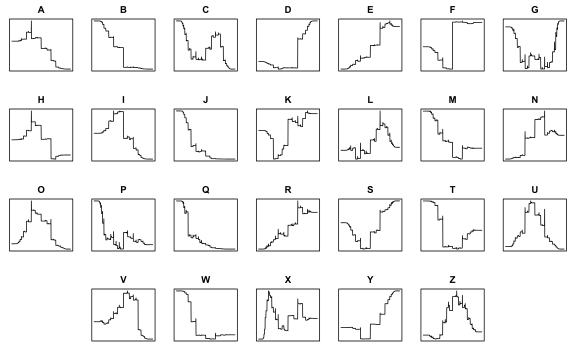

In [9]:
options(repr.plot.width=8, 
        repr.plot.height=5,
        jupyter.plot_mimetypes = "image/svg+xml")

# split plotting window into a 4x7 grid and reduce margins
par(mfrow = c(4,7), mar = c(rep(c(2,1), 2)))
for (l in LETTERS) {
  # position bottom row at centre
  if (l == "V") plot.new()
  plot(freq_mtrx[, l], 
       main = l,
       xlab = "", ylab = "", 
       xaxt = 'n', yaxt = 'n', 
       type = "l")
}

There is clearly a lot of noise in the distributions (which is unsurprising considering the primitiveness of the method used to generate them) but their overall shapes are clearly visible. To highlight these trends, we will fade the current piecewise function and add a LOESS approximation to smooth out the noise.

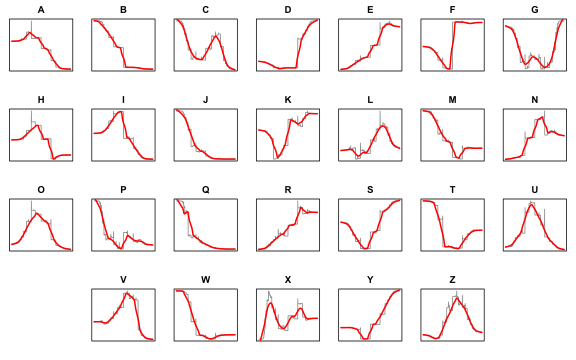

In [10]:
options(repr.plot.width=8, 
        repr.plot.height=5,
        jupyter.plot_mimetypes = "image/svg+xml")

# split plotting window into a 4x7 grid and reduce margins
par(mfrow = c(4,7), mar = c(rep(c(2,1), 2)))
for (l in LETTERS) {
  # position bottom row at centre
  if (l == "V") plot.new()
  plot(freq_mtrx[, l], 
       main = l,
       xlab = "", ylab = "", 
       xaxt = 'n', yaxt = 'n', 
       type = "l", col = "#00000080")
  # add LOESS curve
  lines(lowess(freq_mtrx[, l], f = .2, iter = 10), 
        col = "red", lwd = 2)
}

### Comparision and clustering

Looking at these distributions we can see similarity between between certain letters. For example, 'B' and 'J' both feature heavily at the start of a word and then become less likely to appear as you progress through until at about halfway through the word, the odds drop sharply. Other similar distributions are that of 'A' and 'I' which both start with moderate density then become more common halfway through the word then drop off towards the end.

It would nice to have a way to numerically quantify the similarity of two such distributions. My first instinct was to use a two-sample [Kolmogorov-Smirnov test](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test), a non-parametric hypothesis test for the equality of the two continuous distributions. The hypothesis test itself has little relevance to us as we know the distributions are different already but the test statistic $D$ measuring dissimilarity of the distributions from 0 to 1 would be a useful measurement to obtain. This test, however, behaved very strangely in many ways. For example it said that Z was more similar to R than U which is clearly wrong. I'm not sure of the exact cause of this behaviour but I assume that it is to do with the test being more sensitive to points in common than to differences. As has been the spirit of this post throughout, if there is no working existing solution, why not make your own? I therefore decided to use the trusted [$L^2$-norm](http://mathworld.wolfram.com/L2-Norm.html), a generalisation of the Euclidean distance to vectors or functions, such as the discrete approximations of our densities. Using this metric we can build a dissimilarity matrix as follows.

In [11]:
# function to calculate L2_distance from two rows of the
# count matrix using the LOESS approximations
L2_distance <- Vectorize(function(x, y) {
  x_smooth <- lowess(freq_mtrx[, x], f = .2, iter = 10)$y
  y_smooth <- lowess(freq_mtrx[, y], f = .2, iter = 10)$y
  sqrt(sum((x_smooth - y_smooth)^2))
})

# generate dissimilarity matrix
dissim_matrix <- outer(LETTERS, LETTERS, L2_distance)
rownames(dissim_matrix) <- LETTERS
colnames(dissim_matrix) <- LETTERS

Taking a look at the first few values of the matrix we get the following.

In [12]:
dissim_matrix[1:10, 1:5]

,A,B,C,D,E
A,0.000000,16.776463,12.78744,27.28297,22.359695
B,16.776463,0.000000,18.04045,37.39060,36.416457
C,12.787437,18.040450,0.00000,29.03896,25.082159
D,27.282972,37.390604,29.03896,0.00000,11.546242
E,22.359695,36.416457,25.08216,11.54624,0.000000
F,18.640712,31.657256,18.37488,15.34660,9.030299
G,11.753001,20.592338,14.98968,18.38069,17.744923
H,6.095563,17.449902,17.29474,31.61455,26.434965
I,2.705759,17.945779,14.66834,28.09740,22.766470
J,23.697318,9.318525,20.36490,40.69734,41.005730


As we can see, every letter has a dissimilarity with itself of zero since they have exactly the same distribution. As stated before 'A' and 'I' have similar distributions and this is reflected by the small dissimilarity value of 2.7. We can visualise the entire matrix using a heat map.

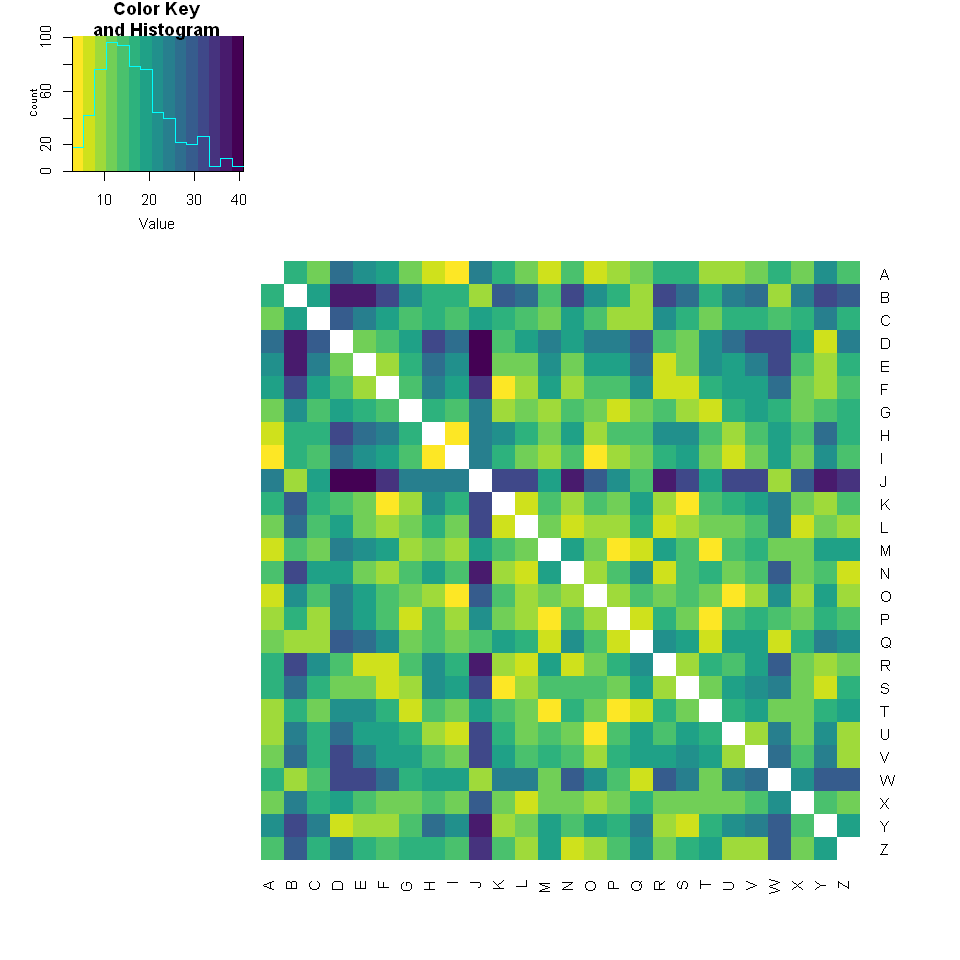

In [13]:
options(repr.plot.width=8, 
        repr.plot.height=8,
        jupyter.plot_mimetypes = "image/png")

# don't show a value for letters paired with themselves
dissim_matrix_na <- dissim_matrix
diag(dissim_matrix_na) <- NA

# create a heatmap using the gplots package
gplots::heatmap.2(dissim_matrix_na, 
                  dendrogram = 'none', 
                  Rowv = FALSE, 
                  Colv = FALSE,
                  trace = 'none', 
                  na.color = "white", 
                  # reverse viridis scale
                  col = viridis::viridis_pal(direction = -1))

This closely matches our expectation. 'E' and 'J' have very different distributions and so have a dark cell with a dissimilarity value in the 30s whereas 'Q' and 'W' are very similar and so have a light cell with a value under 15. 

Now that we have a form of distance metric between any two letter distributions, we can perform cluster analysis. Since we don't have the exact coordinates of the distributions in some general space (though we could formulate this using a method I will soon discuss in another blog post) we can't use k-means clustering. We are instead forced to use an agglomerative method such as hierarchical clustering. We will use the complete linkage method of clustering. This is chosen by elimination more than anything else. We would like a monotone distance measure so that our resulting dendrogram has no inversions so centroid (UPGMC) and median (WPGMA) methods are out of the question. Furthermore, single and average (UPGMA) methods do not force enough similarity within clusters. Lastly, Ward's method of minimum variance will aim to find spherical clusters which is an unreasonable assumption for our data. We therefore proceed with complete linkage to produce the following dendrogram.

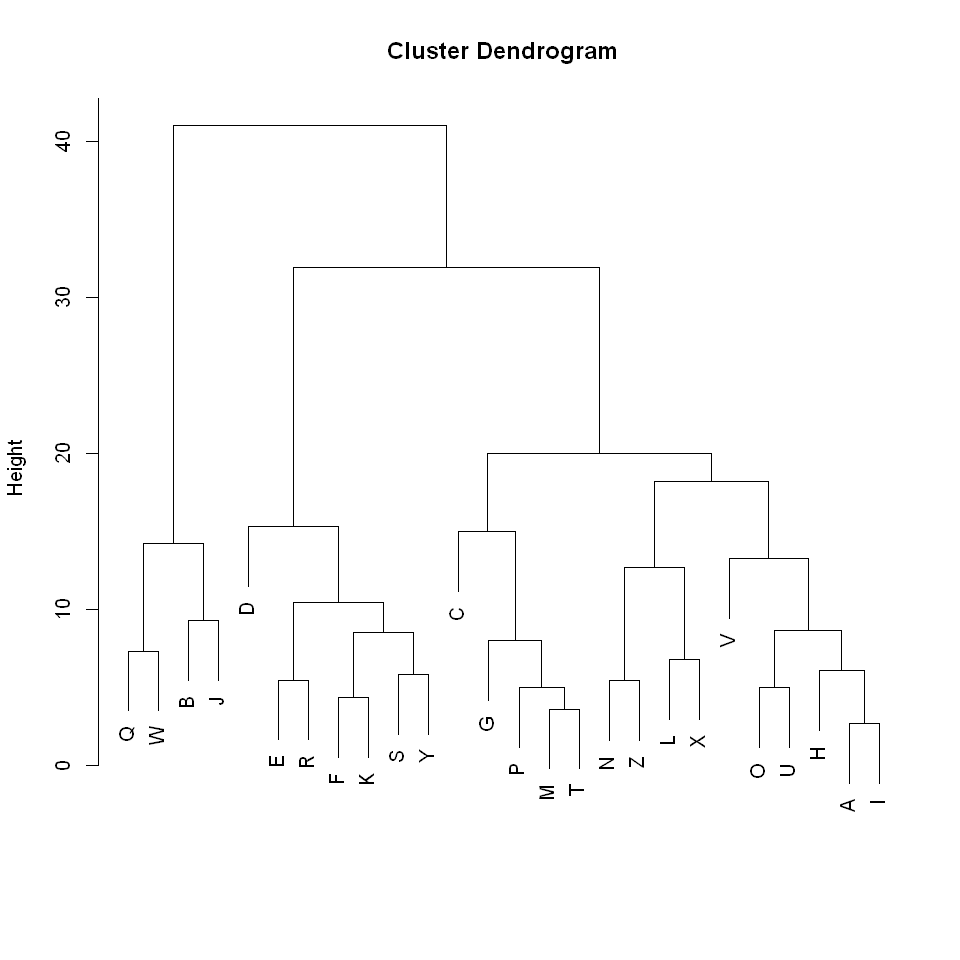

In [14]:
clust <- hclust(as.dist(dissim_matrix), method = "complete")
plot(clust, xlab = "", sub = "")

This, again, matches the behaviour we would expect. The distributions that we previously said were similar such as 'B', 'J', 'Q', and 'W' are clustered very close together whereas the highly dissimilar distributions such as 'E' and 'J' only connect at the max height of 41

From this dendrogram it appears that an appropriate cut would be somewhere between a height of 16 and 21. The exact choice would depend on the number of clusters we were after. I decided to cut at a height of 16, giving the following groupings.

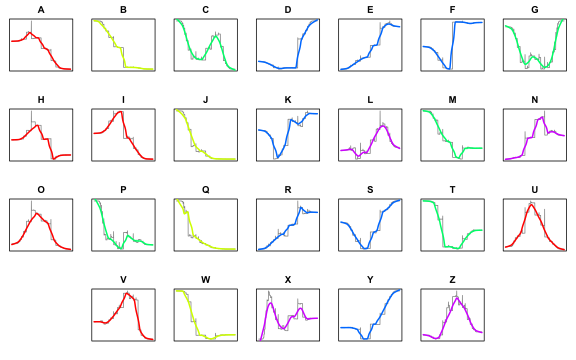

In [15]:
options(repr.plot.width=8, 
        repr.plot.height=5,
        jupyter.plot_mimetypes = "image/svg+xml")

groups <- cutree(clust, h = 16)
palette <- rainbow(length(unique(groups))) 

par(mfrow = c(4,7), mar = c(rep(c(2,1), 2)))
for (l in LETTERS) {
  # position bottom row at centre
  if (l == "V") plot.new()
  plot(freq_mtrx[, l], 
       main = l,
       xlab = "", ylab = "", 
       xaxt = 'n', yaxt = 'n', 
       type = "l", col = "#00000080")
  lines(lowess(freq_mtrx[, l], f = .2, iter = 10), 
        col = palette[groups[l]], lwd = 2)
}

Attempting to categorise these leads to the following possible interpretations of the groupings:

* The red letters are those which feature most prominently in the middle of words, very little at the end and occasionally at the beginning
* The yellow letters are those that are common at the start of a word but become less likely the further towards the end you get
* The green letters are most common at the start of words but barely feature in the middle. They are also reasonably prominent at the end of words ('G' being an outlier due to the common use of 'ing')
* The blue letters feature often at the ends of words but less so at the beginning
* The purple letters appear most often in the middle of the words

The rules have clear exceptions. For example, 'C' could just as easily be categorised as a new colour since it isn't all to similar to the other green letters (this is evident form its late join to that branch of the dendrogram). In general though, this clustering does a promising job of grouping the letters by their functions in words.